In [ ]:
import sys
sys.path.append("../../")

In [2]:
import eventx
from eventx.util import corpus_statistics, scorer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from eventx import SDW_RELATION_TYPES, SDW_ROLE_LABELS

In [3]:
# Change paths
DATASET_PATH = Path("../../data/smartdata-corpus")
TRAIN_PATH = DATASET_PATH.joinpath("train/train_sdw_with_events.jsonl")
DEV_PATH = DATASET_PATH.joinpath("dev/dev_sdw_with_events.jsonl")
TEST_PATH = DATASET_PATH.joinpath("test/test_sdw_with_events.jsonl")

SAVE_PATH = Path("../../data/save_files")                     

In [4]:
train = pd.read_json(TRAIN_PATH, lines=True, encoding='utf8')
dev = pd.read_json(DEV_PATH, lines=True, encoding='utf8')
test = pd.read_json(TEST_PATH, lines=True, encoding='utf8')

# SDW dataset statistics

In [5]:
def convert_to_stats_df(stats, data_sets):
    statistics_df = pd.DataFrame(stats)
    statistics_df['Data set'] = data_sets  
    return statistics_df.set_index('Data set')

In [6]:
general_stats = [corpus_statistics.get_smartdata_general_stats(data_set) for data_set in [train, dev, test]]
general_stats_df = convert_to_stats_df(general_stats, data_sets=["SDW Train", "SDW Dev", "SDW Test"])
trigger_stats = [corpus_statistics.get_trigger_class_frequencies(data_set, event_keyword="events", class_names=SDW_RELATION_TYPES) for data_set in [train, dev, test]]
trigger_stats_df = convert_to_stats_df(trigger_stats, data_sets=["SDW Train", "SDW Dev", "SDW Test"])
role_stats = [corpus_statistics.get_role_class_frequencies(data_set, event_keyword="events", class_names=SDW_ROLE_LABELS) for data_set in [train, dev, test]]
role_stats_df = convert_to_stats_df(role_stats, data_sets=["SDW Train", "SDW Dev", "SDW Test"])

In [7]:
display(general_stats_df.T)

Data set,SDW Train,SDW Dev,SDW Test
# Docs,1861,228,230
# Tokens,113317,13753,14274
# Entities,15463,1874,1779
# Trigger Entities,1244,159,165
# Event Triggers,319,48,42
# Unique Event Triggers,313,45,42
# Arguments,559,82,73
# Docs with event triggers,218,33,34
# Docs with multiple event triggers,50,10,4
# Docs with multiple event triggers with same type,49,10,4


Filtering for SDW event leaves a relatively small dataset overall.
When comparing the number of event triggers (123) and unique event triggers (120), we can see that some events share the same event trigger.
This is similar to what we observed in SD4M.

In [8]:
sdw = pd.concat([train, dev, test])
uniques, counts = np.unique(scorer.get_triggers(sdw.to_dict('records')), return_counts=True, axis=0)
shared_triggers = [trigger for trigger, count in zip(uniques, counts) if count > 1]
len(shared_triggers)

6

In [9]:
rel_docs = sdw.iloc[[shared_trigger[0] for shared_trigger in shared_triggers]][['text', 'events']]
with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(rel_docs.iloc[2]))

,207
text,KONKURS!!! Haul SheIn | Dresslink | Penneys | Doriska https://t.co/sFW95B9vFh via @YouTube\n
events,"[{'event_type': 'Insolvency', 'trigger': {'id': 'c/583f3db8-98bd-47d5-9ff6-b9d0ac7b69d2', 'text': 'KONKURS', 'entity_type': 'trigger', 'start': 0, 'end': 1}, 'arguments': [{'id': 'c/ce24591f-57c9-4100-a34a-37f419189fd9', 'text': 'Penneys', 'entity_type': 'organization-company', 'start': 7, 'end': 8, 'role': 'company'}]}, {'event_type': 'Insolvency', 'trigger': {'id': 'c/583f3db8-98bd-47d5-9ff6-b9d0ac7b69d2', 'text': 'KONKURS', 'entity_type': 'trigger', 'start': 0, 'end': 1}, 'arguments': [{'id': 'c/5f79d5df-8306-4560-8bed-5e5a30147976', 'text': 'Doriska', 'entity_type': 'organization-company', 'start': 9, 'end': 10, 'role': 'company'}]}, {'event_type': 'Insolvency', 'trigger': {'id': 'c/583f3db8-98bd-47d5-9ff6-b9d0ac7b69d2', 'text': 'KONKURS', 'entity_type': 'trigger', 'start': 0, 'end': 1}, 'arguments': [{'id': 'c/3c43b335-dad8-4df4-af83-0123ae21bd8f', 'text': 'SheIn', 'entity_type': 'organization-company', 'start': 3, 'end': 4, 'role': 'company'}]}, {'event_type': 'Insolvency', 'trigger': {'id': 'c/583f3db8-98bd-47d5-9ff6-b9d0ac7b69d2', 'text': 'KONKURS', 'entity_type': 'trigger', 'start': 0, 'end': 1}, 'arguments': [{'id': 'c/d654700f-d6ae-48da-8ce8-9005e97931e0', 'text': 'Dresslink', 'entity_type': 'organization-company', 'start': 5, 'end': 6, 'role': 'company'}]}]"


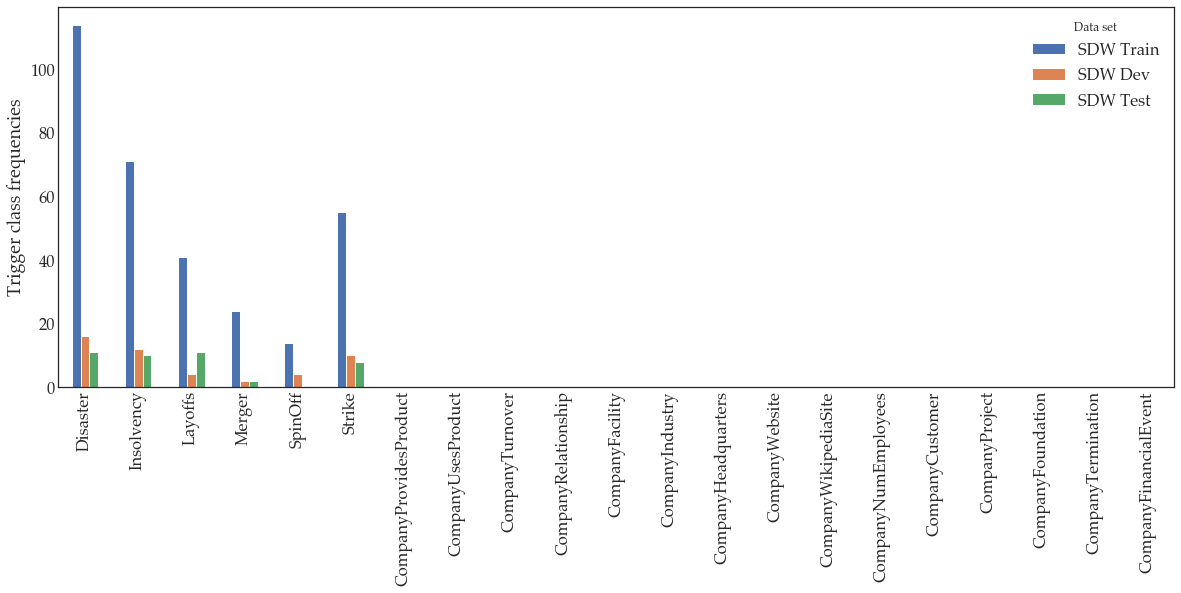

In [10]:
sns.set(font_scale=1.5, font="Palatino")
with plt.style.context("seaborn-white"):
    plt.rcParams["font.family"] = "Palatino"
    plt.rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(1, 1, figsize=(20,7))
    trigger_plot = trigger_stats_df[SDW_RELATION_TYPES[:-1]].T.plot.bar(ax=ax)
    ax.set_ylabel('Trigger class frequencies')
    trigger_plot.set_xticklabels(trigger_plot.get_xticklabels(), rotation = 90)
    handles, labels = ax.get_legend_handles_labels()
    fig.savefig(SAVE_PATH.joinpath('SDW-Event_Stats.pdf'), bbox_inches='tight')

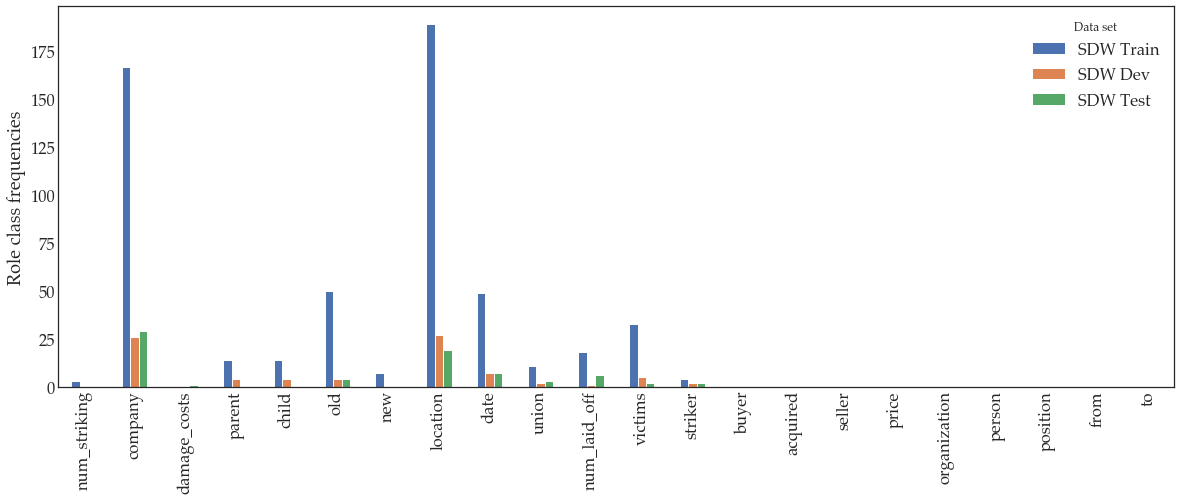

In [11]:
sns.set(font_scale=1.5, font="Palatino")
with plt.style.context("seaborn-white"):
    plt.rcParams["font.family"] = "Palatino"
    plt.rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(1, 1, figsize=(20,7))
    role_plot = role_stats_df[SDW_ROLE_LABELS[:-1]].T.plot.bar(ax=ax)
    ax.set_ylabel('Role class frequencies')
    role_plot.set_xticklabels(role_plot.get_xticklabels(), rotation = 90)
    handles, labels = ax.get_legend_handles_labels()
    fig.savefig(SAVE_PATH.joinpath('SDW-Role_Stats.pdf'), bbox_inches='tight')

# SDW eventx model performance

In [12]:
from eventx.predictors.predictor_utils import load_predictor
from eventx.models.model_utils import batched_predict_json
from eventx.util import scorer, utils, evaluate

In [13]:
CUDA_DEVICE = -1  # or -1 if no GPU is available
PREDICTOR_NAME = "smartdata-eventx-predictor"
REMOVE_DUPLICATES = True  # change to False if you want to keep duplicate triggers/ arguments from the gold data caused by events sharing the same trigger

model_path = Path("../../data/runs/bert_smartdata")

In [14]:
test_docs = evaluate.load_test_data(TEST_PATH)
gold_triggers = scorer.get_triggers(test_docs)
gold_arguments = scorer.get_arguments(test_docs)

print(f'Number of gold triggers: {len(gold_triggers)}')
print(f'Number of gold arguments: {len(gold_arguments)}')
if REMOVE_DUPLICATES:
    gold_triggers = list(set(gold_triggers))
    gold_arguments = list(set(gold_arguments))
    print(f'After removing duplicate triggers/ arguments from the gold data caused by events sharing the same trigger')
    print(f'Number of unique gold triggers: {len(gold_triggers)}')
    print(f'Number of unique gold arguments: {len(gold_arguments)}')

Number of gold triggers: 42
Number of gold arguments: 73
After removing duplicate triggers/ arguments from the gold data caused by events sharing the same trigger
Number of unique gold triggers: 42
Number of unique gold arguments: 73


In [15]:
model_base_path = Path("../../data/runs/random_repeats_sdw")
model_names = [f"run_{i+1}" for i in range(5)]
trigger_metrics_rr, argument_metrics_rr = {}, {}
model_paths = [model_base_path.joinpath(model_name) for model_name in model_names]
trigger_metrics_rr, argument_metrics_rr = evaluate.summize_multiple_runs(model_paths, test_docs, 
                                                                         predictor_name=PREDICTOR_NAME,
                                                                         relation_types=SDW_RELATION_TYPES,
                                                                          role_classes=SDW_ROLE_LABELS)

2021-01-04 11:26:42,588 - Collecting metrics for the 5 models
INFO:eventx:Collecting metrics for the 5 models
2021-01-04 11:26:42,589 - Working on 1. model.
INFO:eventx:Working on 1. model.
100%|██████████| 7/7 [00:27<00:00,  3.86s/it]
2021-01-04 11:27:20,788 - Working on 2. model.
INFO:eventx:Working on 2. model.
100%|██████████| 7/7 [00:27<00:00,  3.91s/it]
2021-01-04 11:27:52,655 - Working on 3. model.
INFO:eventx:Working on 3. model.
100%|██████████| 7/7 [00:25<00:00,  3.66s/it]
2021-01-04 11:28:23,151 - Working on 4. model.
INFO:eventx:Working on 4. model.
100%|██████████| 7/7 [00:28<00:00,  4.09s/it]
2021-01-04 11:28:56,670 - Working on 5. model.
INFO:eventx:Working on 5. model.
100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


In [16]:
trigger_related_categories = ["Trigger identification", "Trigger classification"] + SDW_RELATION_TYPES[:-1]
role_related_categories = ["Argument identification", "Argument classification"] + SDW_ROLE_LABELS[:-1]

In [17]:
formatted_trigger = evaluate.format_classification_report(evaluate.get_mean_std(trigger_metrics_rr), make_string=True)
formatted_argument = evaluate.format_classification_report(evaluate.get_mean_std(argument_metrics_rr), make_string=True)
formatted_metrics = pd.concat([formatted_trigger, formatted_argument])
formatted_metrics.set_index('row_name', inplace=True)

In [18]:
formatted_metrics.T[[tr_cat for tr_cat in trigger_related_categories if tr_cat in formatted_metrics.T]]

row_name,Trigger identification,Trigger classification,Disaster,Insolvency,Layoffs,Merger,Strike
precision,85.9+/- 2.4,85.2+/- 2.9,87.1+/- 12.4,89.1+/- 0.9,78.8+/- 7.1,56.7+/- 8.2,100.0+/- 0.0
recall,61.0+/- 4.9,60.5+/- 5.3,43.6+/- 6.8,82.0+/- 7.5,41.8+/- 9.3,90.0+/- 20.0,75.0+/- 13.7
f1-score,71.2+/- 3.7,70.6+/- 4.2,57.7+/- 6.9,85.2+/- 4.5,54.3+/- 9.5,68.7+/- 11.1,85.0+/- 9.8
support,42,42,11,10,11,2,8


In [19]:
formatted_metrics.T[[rr_cat for rr_cat in role_related_categories if rr_cat in formatted_metrics.T]]

row_name,Argument identification,Argument classification,company,damage_costs,old,location,date,union,num_laid_off,victims,striker
precision,53.3+/- 1.8,51.0+/- 2.9,57.4+/- 4.6,0.0+/- 0.0,19.3+/- 10.1,66.8+/- 11.3,13.3+/- 19.4,60.0+/- 49.0,0.0+/- 0.0,40.0+/- 49.0,0.0+/- 0.0
recall,33.2+/- 3.2,31.8+/- 4.0,46.2+/- 7.4,0.0+/- 0.0,45.0+/- 24.5,34.7+/- 5.4,5.7+/- 7.0,20.0+/- 16.3,0.0+/- 0.0,20.0+/- 24.5,0.0+/- 0.0
f1-score,40.8+/- 2.6,39.1+/- 3.7,50.9+/- 5.5,0.0+/- 0.0,27.0+/- 14.3,45.1+/- 5.4,7.5+/- 9.5,30.0+/- 24.5,0.0+/- 0.0,26.7+/- 32.7,0.0+/- 0.0
support,73,73,29,1,4,19,7,3,6,2,2
